# Energy Management in Building Project 

## INTRODUCTION

The aim of this project is to ...

## PART 1 - PYTHON MODELLING

In this first part, the aim is to create a model to study the evolution of temperature on a studio. Then, we compare the python model with the results from the same model in Design Builder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

### General presentation of the building 

#### Description of the studio

The studied apartment is a studio of 32 $m^{2}$, with 2 rooms : a living room of 24 $m^{2}$ and a bathroom of 8 $m^{2}$. This studio is located in an angle of the dwelling building : two sides are in contact with the outdoor. Its dimensions and material composition are given on the following figure :

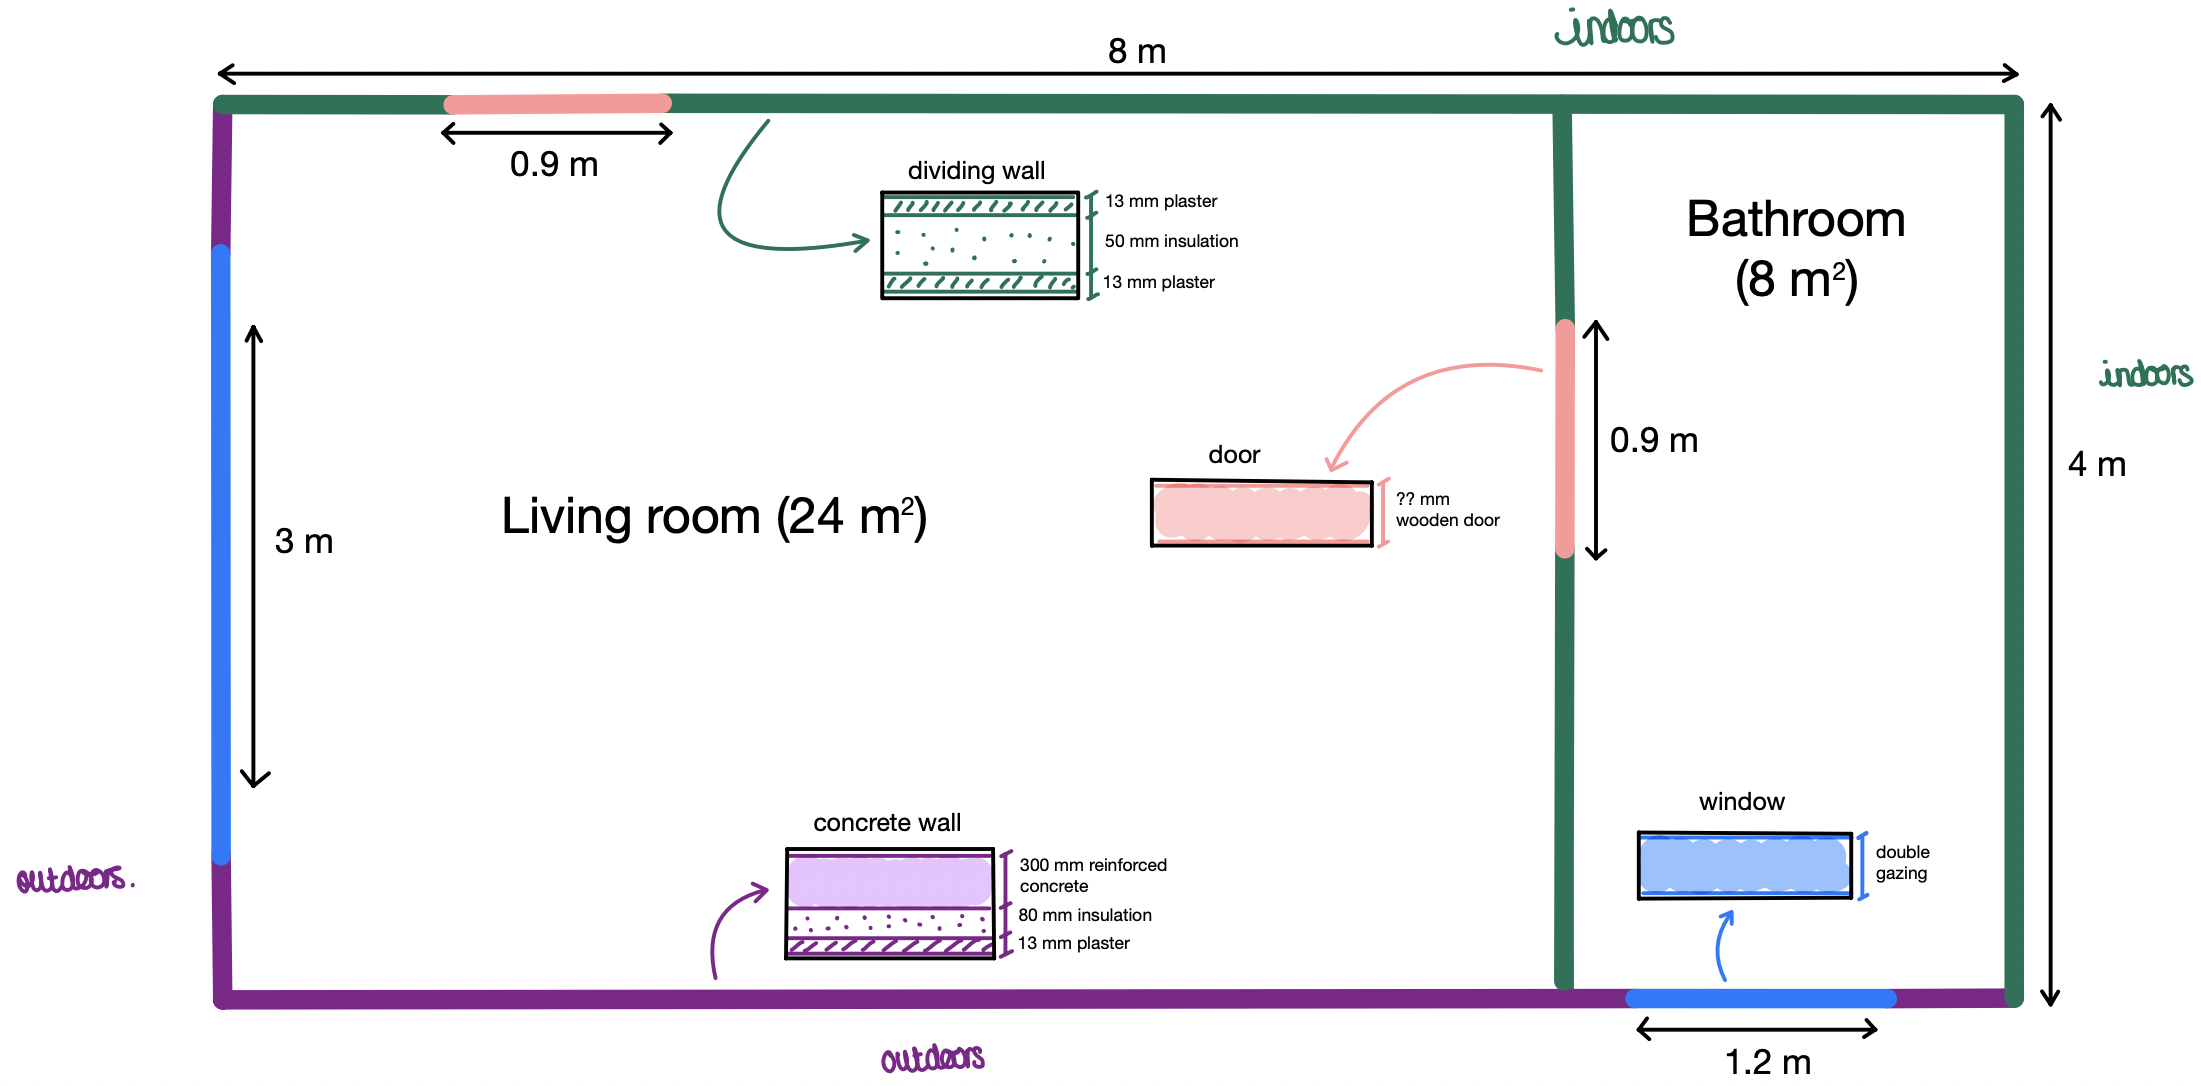

Let’s consider two rooms with a ventilation system and an HVAC system controlled by a P-controller.

In [2]:
# Physical values
# ===============
# P-controler gain
# ----------------
# Kp = 1e4            # Kp -> ∞ : almost perfect controller
Kp = 1e-3         # Kp -> 0 : no controller Kp -> 0
Kp

0.001

#### Physical analysis and mathematical modelling

The building has two systems of ventilation : one in the living room and the other one in the bathroom. The volumis air flow rates are `Va_dot`: 

In [3]:
# Air-flow rate
# -------------
Va_livingroom = 6 * 4 * 2.5        # m³ volume of air  in the living room
Va_bathroom = 2 * 4 * 2.5          # m³ volume of air  in the bathroom
ACH = 1             # air changes per hour
Va_livingroom_dot = ACH * Va_livingroom / 3600    # m³/s air infiltration
Va_bathroom_dot = ACH * Va_bathroom / 3600

The thermophysical properties of the air are : 

In [4]:
# Thermophysical properties
# ------------------------
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K

The thermophysical properties of the materials are :

In [5]:
# Thermophyscal properties
# ------------------------
materials = {'Conductivity': [2.3, 0.0457, 0.25, 0.19, 1.4],   # W/m.K
             'Density': [2300, 40, 2800, 700, 2100],           # kg/m³
             'Specific heat': [1000, 1450, 896, 2390, 840],    # J/kg.K
             'Width': [0.3, 0.05, 0.013, 0.035, 0.1],          # m
             'Slice': [1, 1, 1, 1, 1]}                         # nb of meshes
materials = pd.DataFrame(
    materials, index=['Concrete', 'Insulation', 'Plaster', 'Door',
                      'Floor'])
materials

,Conductivity,Density,Specific heat,Width,Slice
Concrete,2.3000,2300,1000,0.300,1
Insulation,0.0457,40,1450,0.050,1
Plaster,0.2500,2800,896,0.013,1
Door,0.1900,700,2390,0.035,1
Floor,1.4000,2100,840,0.100,1


The surface areas of the materials in the wall are :

In [6]:
# Surfaces
surfaces = {'LR': [13.11, 18.4, 6.6, 1.89, 48],      # m²
            'BR': [15, 3.8, 1.2, 0, 16],
            'LR-BR': [8.11, 0, 0, 1.89, 0]}
surfaces = pd.DataFrame(
    surfaces, index=['Dividingwall', 'Wall', 'Window', 'Door', 'Floor'])
surfaces

,LR,BR,LR-BR
Dividingwall,13.11,15.0,8.11
Wall,18.40,3.8,0.00
Window,6.60,1.2,0.00
Door,1.89,0.0,1.89
Floor,48.00,16.0,0.00


In the following parts, we will note 'LR' for living room and 'BR' for bathroom. 'LR-BR' will correspond to the partition between the two rooms.

Here are the convection coefficients :

In [7]:
# convection coefficients, W/m² K
h = pd.DataFrame([{'in': 4., 'out': 10}])

### Thermal network model

#### Hypothesis

We made some assumptions in order to model the situation :
- the outdoor temperature is given by weather data of Lyon
- the temperature in the neighboring apartments and in the corridor is fixed at 20°C 
- in our studio, the setpoint temperature in the living room is 21°C and the setpoint temperature in the bathroom is 23°C
- the modeling of the window is simplified : it has a short time response, that we will consider instantenous compared to the time step of 10-15 minutes
- the double-glazed window chosen has a thermal coefficient Uw = 1,96 W/m²K for the whole window (frame + glass). This coefficient is the same on the simulation on Design Builder.
- ventilation and window are modelling together, with only one resistance.
- 

#### Thermal network model

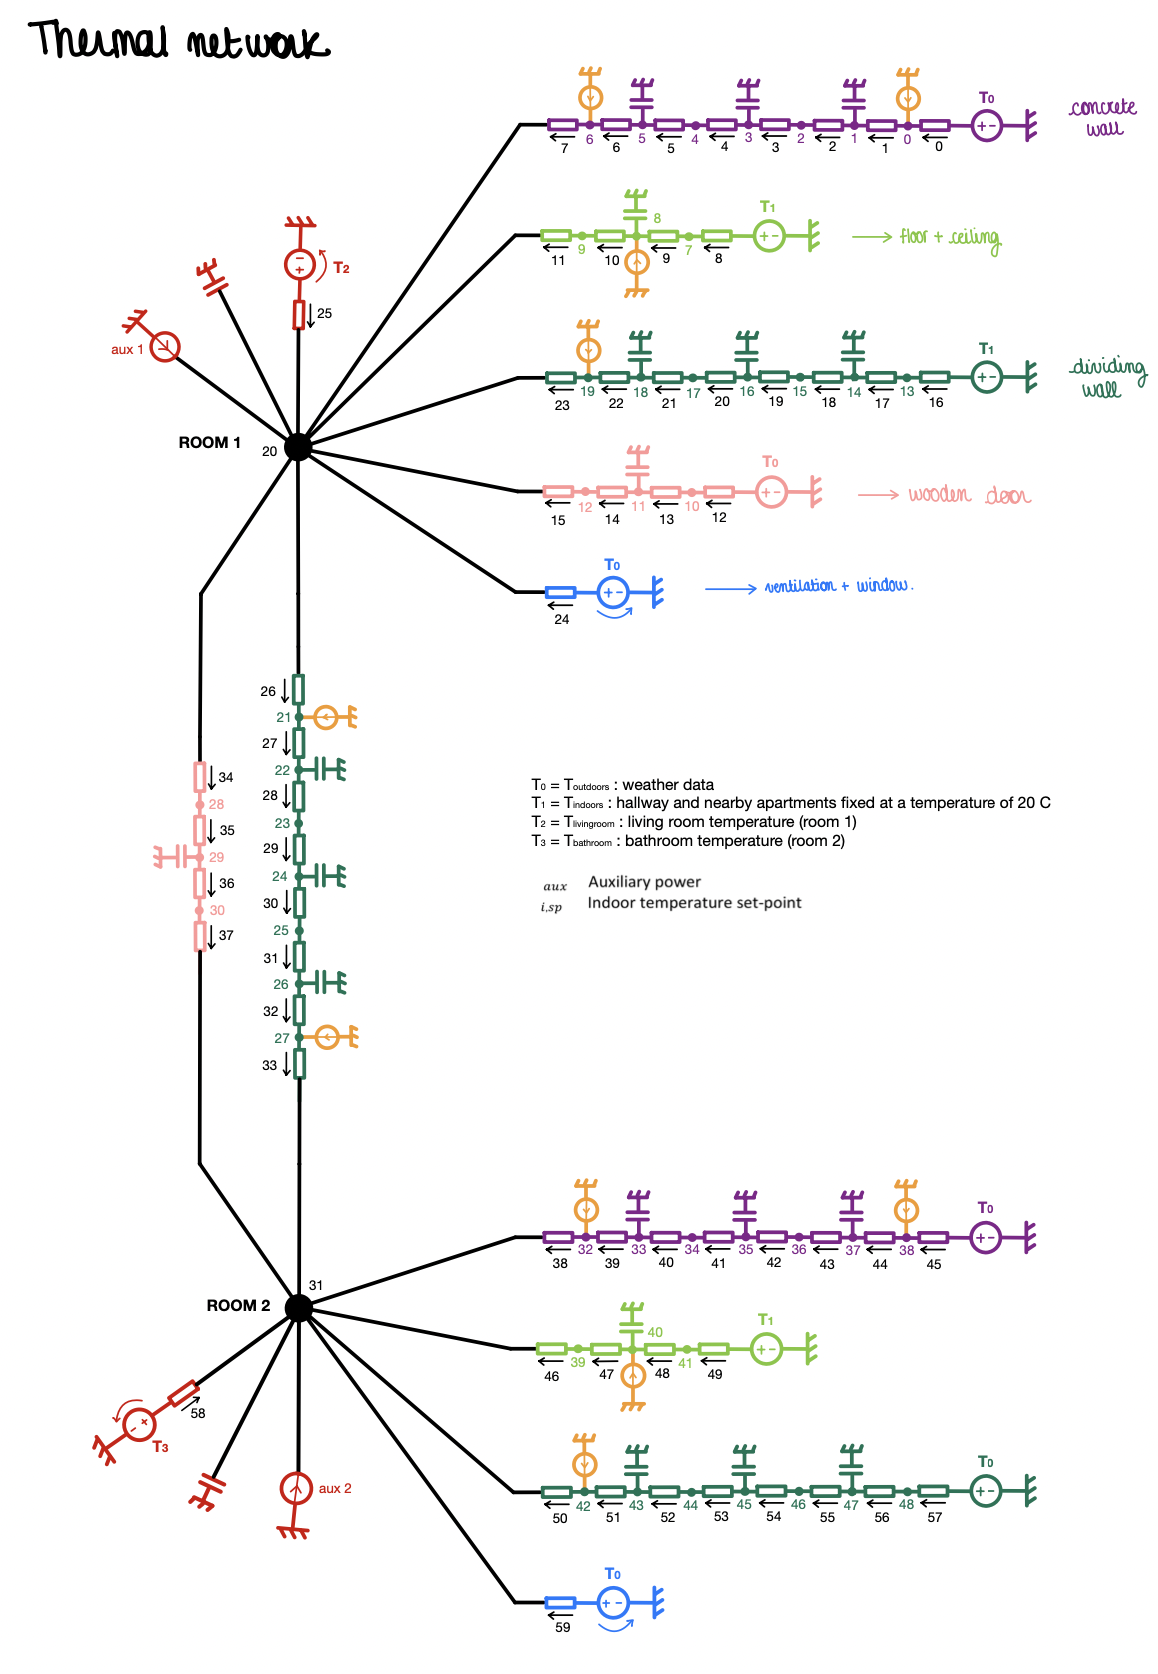 

The nodes are numbered from 0 to 48. The conductances are numbered from 0 to 59.

#### Resistances and capacities

**Thermal conductances**

The conductance is the inverse of the thermal resistance.

For conduction : 
$$G_{cd} = \frac{\lambda S}{w}$$

For convection :
$$G_{cv} = {h S}$$

Where :
- $w$ is the width of the material (m)
- $\lambda$ - thermal conductvity (W/m.K)
- $S$ is the surface area of the wall (m²)
- $h$ is the convection coefficient (W/m² K)

In [8]:
# Thermal conductances
# --------------------
# Conduction
# Conduction zone 1 : LR
#            in wall
Gcd_LR_w_c = materials['Conductivity']['Concrete'] / \
    materials['Width']['Concrete'] * surfaces['LR']['Wall']

Gcd_LR_w_i = materials['Conductivity']['Insulation'] / \
    materials['Width']['Insulation'] * surfaces['LR']['Wall']

Gcd_LR_w_p = materials['Conductivity']['Plaster'] / \
    materials['Width']['Plaster'] * surfaces['LR']['Wall']

#            in dividing wall
Gcd_LR_dw_p = materials['Conductivity']['Plaster'] / \
    materials['Width']['Plaster'] * surfaces['LR']['Dividingwall']

Gcd_LR_dw_i = materials['Conductivity']['Insulation'] / \
    materials['Width']['Insulation'] * surfaces['LR']['Dividingwall']

#           door
Gcd_LR_d = materials['Conductivity']['Door'] / \
    materials['Width']['Door'] * surfaces['LR']['Door']

#           floor
Gcd_LR_f = materials['Conductivity']['Floor'] / \
    materials['Width']['Floor'] * surfaces['LR']['Floor']

# Conduction zone 2 : BR
#            in wall
Gcd_BR_w_c = materials['Conductivity']['Concrete'] / \
    materials['Width']['Concrete'] * surfaces['BR']['Wall']

Gcd_BR_w_i = materials['Conductivity']['Insulation'] / \
    materials['Width']['Insulation'] * surfaces['BR']['Wall']

Gcd_BR_w_p = materials['Conductivity']['Plaster'] / \
    materials['Width']['Plaster'] * surfaces['BR']['Wall']

#            in dividing wall
Gcd_BR_dw_p = materials['Conductivity']['Plaster'] / \
    materials['Width']['Plaster'] * surfaces['BR']['Dividingwall']

Gcd_BR_dw_i = materials['Conductivity']['Insulation'] / \
    materials['Width']['Insulation'] * surfaces['BR']['Dividingwall']

#           floor
Gcd_BR_f = materials['Conductivity']['Floor'] / \
    materials['Width']['Floor'] * surfaces['BR']['Floor']

# Conduction zone 3 : LR-BR
#            in dividing wall
Gcd_LRBR_dw_p = materials['Conductivity']['Plaster'] / \
    materials['Width']['Plaster'] * surfaces['LR-BR']['Dividingwall']

Gcd_LRBR_dw_i = materials['Conductivity']['Insulation'] / \
    materials['Width']['Insulation'] * surfaces['LR-BR']['Dividingwall']

#           door
Gcd_LRBR_d = materials['Conductivity']['Door'] / \
    materials['Width']['Door'] * surfaces['LR-BR']['Door']

# Convection
# Convection zone 1 : LR
Gcv_LR_w = h * surfaces['LR']['Wall']               # in wall

Gcv_LR_dw = h * surfaces['LR']['Dividingwall']      # in in dividing wall

Gcv_LR_d = h * surfaces['LR']['Door']               # door

Gcv_LR_f = h * surfaces['LR']['Floor']              # floor

# Convection zone 2 : BR
Gcv_BR_w = h * surfaces['BR']['Wall']               # in wall

Gcv_BR_dw = h * surfaces['BR']['Dividingwall']      # in in dividing wall

Gcv_BR_f = h * surfaces['BR']['Floor']              # floor

# Convection zone 3 : LR-BR
Gcv_LRBR_dw = h * surfaces['LR-BR']['Dividingwall']   # in in dividing wall

Gcv_LRBR_d = h * surfaces['LR-BR']['Door']           # door

# Ventilation & advection
Gv_LR = Va_livingroom_dot * air['Density'] * air['Specific heat']

Gv_BR = Va_bathroom * air['Density'] * air['Specific heat']

# Window : conductance Uw * S
Uw = 1.96   # W/(m2.K) for double-glazed, from DesignBuilder

Gw_LR = Uw * surfaces['LR']['Window']

Gw_BR = Uw * surfaces['BR']['Window']

# Renouvellement d'air
Gr_LR = Gr_BR = Kp

**Thermal capacities**

The capacity for a material is :

$$C_{material} = \rho_{material} c_{material} w_{material} S_{material}$$

Where : 
- $\rho$ is the density of the material (kg/m³)
- $c$ is the specific heat of the material (J/kg.K)
- $w$ is the width of the material (m)
- $S$ is the surface area (m²)

In [9]:
# Thermal capacities
# ------------------
# zone 1 : LR
C_LR_w_c = materials['Density']['Concrete'] * \
    materials['Specific heat']['Concrete'] * \
    surfaces['LR']['Wall'] * materials['Width']['Concrete']

C_LR_w_i = materials['Density']['Insulation'] * \
    materials['Specific heat']['Insulation'] * \
    surfaces['LR']['Wall'] * materials['Width']['Insulation']

C_LR_w_p = materials['Density']['Plaster'] * \
    materials['Specific heat']['Plaster'] * \
    surfaces['LR']['Wall'] * materials['Width']['Plaster']

C_LR_dw_p = materials['Density']['Plaster'] * \
    materials['Specific heat']['Plaster'] * \
    surfaces['LR']['Dividingwall'] * materials['Width']['Plaster']

C_LR_dw_i = materials['Density']['Insulation'] * \
    materials['Specific heat']['Insulation'] * \
    surfaces['LR']['Dividingwall'] * materials['Width']['Insulation']

C_LR_d = materials['Density']['Door'] * \
    materials['Specific heat']['Door'] * \
    surfaces['LR']['Door'] * materials['Width']['Door']

C_LR_f = materials['Density']['Floor'] * \
    materials['Specific heat']['Floor'] * \
    surfaces['LR']['Floor'] * materials['Width']['Floor']

# zone 2 : BR
C_BR_w_c = materials['Density']['Concrete'] * \
    materials['Specific heat']['Concrete'] * \
    surfaces['BR']['Wall'] * materials['Width']['Concrete']

C_BR_w_i = materials['Density']['Insulation'] * \
    materials['Specific heat']['Insulation'] * \
    surfaces['BR']['Wall'] * materials['Width']['Insulation']

C_BR_w_p = materials['Density']['Plaster'] * \
    materials['Specific heat']['Plaster'] * \
    surfaces['BR']['Wall'] * materials['Width']['Plaster']

C_BR_dw_p = materials['Density']['Plaster'] * \
    materials['Specific heat']['Plaster'] * \
    surfaces['BR']['Dividingwall'] * materials['Width']['Plaster']

C_BR_dw_i = materials['Density']['Insulation'] * \
    materials['Specific heat']['Insulation'] * \
    surfaces['BR']['Dividingwall'] * materials['Width']['Insulation']

C_BR_f = materials['Density']['Floor'] * \
    materials['Specific heat']['Floor'] * \
    surfaces['BR']['Floor'] * materials['Width']['Floor']

# zone 3 : LR-BR
C_LRBR_dw_p = materials['Density']['Plaster'] * \
    materials['Specific heat']['Plaster'] * \
    surfaces['LR-BR']['Dividingwall'] * materials['Width']['Door']

C_LRBR_dw_i = materials['Density']['Insulation'] * \
    materials['Specific heat']['Insulation'] * \
    surfaces['LR-BR']['Dividingwall'] * materials['Width']['Insulation']

C_LRBR_d = materials['Density']['Door'] * \
    materials['Specific heat']['Door'] * \
    surfaces['LR-BR']['Door'] * materials['Width']['Door']

# air
C_LR_air = air['Density'] * air['Specific heat'] * Va_livingroom

C_BR_air = air['Density'] * air['Specific heat'] * Va_bathroom

#### Differential algebraic equations

**Incidence matrix A**

The incidence matrix describes the connections of the temperature nodes by the heat flow branches. The number of columns corresponds to the temperature nodes and the number of lines is equal to the number of heat flows. If the flow enters the nodes, the corresponding value is 1. If the flow goes out, it is -1.

In [10]:
# Incidence matrix A
# ------------------
A = np.zeros([60, 49])

# Flux directed to livingroom
A[0,   0] = 1
A[1,   0], A[1,   1] = -1, 1
A[2,   1], A[2,   2] = -1, 1
A[3,   2], A[3,   3] = -1, 1
A[4,   3], A[4,   4] = -1, 1
A[5,   4], A[5,   5] = -1, 1
A[6,   5], A[6,   6] = -1, 1
A[7,   6], A[7,  20] = -1, 1
A[8,   7] = 1
A[9,   7], A[9,   8] = -1, 1
A[10,  8], A[10,  9] = -1, 1
A[11,  9], A[11, 20] = -1, 1
A[12, 10] = 1
A[13, 10], A[13, 11] = -1, 1
A[14, 11], A[14, 12] = -1, 1
A[15, 12], A[15, 20] = -1, 1
A[16, 13] = 1
A[17, 13], A[17, 14] = -1, 1
A[18, 14], A[18, 15] = -1, 1
A[19, 15], A[19, 16] = -1, 1
A[20, 16], A[20, 17] = -1, 1
A[21, 17], A[21, 18] = -1, 1
A[22, 18], A[22, 19] = -1, 1
A[23, 19], A[23, 20] = -1, 1
A[24, 20] = 1
A[25, 20] = 1
A[26, 20], A[26, 21] = -1, 1
A[27, 21], A[27, 22] = -1, 1
A[28, 22], A[28, 23] = -1, 1
A[29, 23], A[29, 24] = -1, 1
A[30, 24], A[30, 25] = -1, 1
A[31, 25], A[31, 26] = -1, 1
A[32, 26], A[32, 27] = -1, 1
A[33, 27], A[33, 31] = -1, 1
A[34, 28] = 1
A[35, 28], A[35, 29] = -1, 1
A[36, 29], A[36, 30] = -1, 1
A[37, 30], A[37, 31] = -1, 1

# Flux directed to bathroom
A[38, 31], A[38, 32] = 1, -1
A[39, 32], A[39, 33] = 1, -1
A[40, 33], A[40, 34] = 1, -1
A[41, 34], A[41, 35] = 1, -1
A[42, 35], A[42, 36] = 1, -1
A[43, 36], A[43, 37] = 1, -1
A[44, 37], A[44, 38] = 1, -1
A[45, 38] = 1
A[46, 31], A[46, 39] = 1, -1
A[47, 39], A[47, 40] = 1, -1
A[48, 40], A[48, 41] = 1, -1
A[49, 41] = 1
A[50, 31], A[50, 42] = 1, -1
A[51, 42], A[51, 43] = 1, -1
A[52, 43], A[52, 44] = 1, -1
A[53, 44], A[53, 45] = 1, -1
A[54, 45], A[54, 46] = 1, -1
A[55, 46], A[55, 47] = 1, -1
A[56, 47], A[56, 48] = 1, -1
A[57, 48] = 1
A[58, 31] = 1
A[59, 31] = 1

A

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

**Capacity matrix C**

The capacity matrix is a diagonal matrix containing the values of capacities previously calculated. When there is no capacity in a node, the corresponding value is equal to 0.

For the rest of the simulation, we need to fix at 0 some capacities that are minor, in order to have a coherent step-time. The capacitie of the air in the bathroom and the capacities of insulation are neglected.

In [11]:
# Capacity matrix C
# -----------------
C = np.zeros([49, 49])

C_BR_air = C_BR_dw_i = C_BR_w_i = C_LR_dw_i = C_LRBR_dw_i = 0

# Livingroom : LR
# wall (ext)
C[1, 1] = C_LR_w_c
C[3, 3] = C_LR_w_i
C[5, 5] = C_LR_w_p
# floor
C[8, 8] = C_LR_f
# dividingwall
C[14, 14] = C[18, 18] = C_LR_dw_p
C[16, 16] = C_LR_dw_i
# door
C[11, 11] = C_LR_d
# air
C[20, 20] = C_LR_air

# Partition wall : LR-BR
# dividingwall
C[22, 22] = C[26, 26] = C_LRBR_dw_p
C[24, 24] = C_LRBR_dw_i
# door
C[29, 29] = C_LRBR_d

# Bathroom
# wall (ext)
C[37, 37] = C_BR_w_c
C[35, 35] = C_BR_w_i
C[33, 33] = C_BR_w_p
# floor
C[40, 40] = C_BR_f
# dividingwall
C[47, 47] = C[43, 43] = C_BR_dw_p
C[45, 45] = C_BR_dw_i
# air
C[31, 31] = C_BR_air

**Conductance matrix G**

The conductance matrix is a diagonal matrix containing the different values of the conductances.

In [12]:
# Conductance matrix G
# --------------------
G = np.zeros([60, 60])

# Livingroom
# wall (ext)
# convection
G[0, 0] = Gcv_LR_w['out']  # convection wall concrete out
# conduction
G[1, 1] = G[2, 2] = Gcd_LR_w_c  # conduction wall concrete
G[3, 3] = G[4, 4] = Gcd_LR_w_i  # conduction wall insulation
G[5, 5] = G[6, 6] = Gcd_LR_w_p  # conduction wall plaster
# convection
G[7, 7] = Gcv_LR_w['in']  # convection wall plaster inside

# floor
# convection
G[8, 8] = Gcv_LR_f['in']  # convection floor temp fix
# conduction
G[9, 9] = G[10, 10] = Gcd_LR_f  # conduction floor
# convection
G[11, 11] = Gcv_LR_f['in']  # convection floor inside

# door
# convection
G[12, 12] = Gcv_LR_d['in']  # convection door temp fix
# conduction
G[13, 13] = G[14, 14] = Gcd_LR_d  # conduction door
# convection
G[15, 15] = Gcv_LR_d['in']  # convection door inside

# dividing wall
# convection
G[16, 16] = Gcv_LR_dw['in']  # convection d-wall plaster fix
# conduction
G[17, 17] = G[18, 18] = Gcd_LR_dw_p  # conduction d-wall plaster
G[19, 19] = G[20, 20] = Gcd_LR_dw_i  # conduction d-wall insulation
G[21, 21] = G[22, 22] = Gcd_LR_dw_p  # conduction d-wall plaster
# convection
G[23, 23] = Gcv_LR_dw['in']  # convection wall plaster inside

# window + ventilation
# conduction
G[24, 24] = Gw_LR + Gv_LR  # conduction w + venti

# renouvellement air
# conduction
G[25, 25] = Gr_LR  # renouv air LR

# partition wall
# convection
G[26, 26] = Gcv_LRBR_dw['in']  # convection d-wall plaster in
# conduction
G[27, 27] = G[28, 28] = Gcd_LRBR_dw_p  # conduction d-wall plaster
G[29, 29] = G[30, 30] = Gcd_LRBR_dw_i  # conduction d-wall insulation
G[31, 31] = G[32, 32] = Gcd_LRBR_dw_p  # conduction d-wall plaster
# convection
G[33, 33] = Gcv_LRBR_dw['in']  # convection wall plaster inside

# door
# convection
G[34, 34] = Gcv_LRBR_d['in']  # convection door temp fix
# conduction
G[35, 35] = G[36, 36] = Gcd_LRBR_d  # conduction door
# convection
G[37, 37] = Gcv_LRBR_d['in']  # convection door inside

# Bathroom
# wall (ext)
# convection
G[45, 45] = Gcv_BR_w['out']  # convection wall concrete out
# conduction
G[44, 44] = G[43, 43] = Gcd_BR_w_c  # conduction wall concrete
G[42, 42] = G[41, 41] = Gcd_BR_w_i  # conduction wall insulation
G[40, 40] = G[39, 39] = Gcd_BR_w_p  # conduction wall plaster
# convection
G[38, 38] = Gcv_BR_w['in']  # convection wall plaster inside

# floor
# convection
G[49, 49] = Gcv_BR_f['in']  # convection floor temp fix
# conduction
G[48, 48] = G[47, 47] = Gcd_BR_f  # conduction floor
# convection
G[46, 46] = Gcv_BR_f['in']  # convection floor inside

# dividing wall
# convection
G[57, 57] = Gcv_BR_dw['in']  # convection d-wall plaster fix
# conduction
G[56, 56] = G[55, 55] = Gcd_BR_dw_p  # conduction d-wall plaster
G[54, 54] = G[53, 53] = Gcd_BR_dw_i  # conduction d-wall insulation
G[52, 52] = G[51, 51] = Gcd_BR_dw_p  # conduction d-wall plaster
# convection
G[50, 50] = Gcv_BR_dw['in']  # convection wall plaster inside

# window + ventilation
# conduction
G[59, 59] = Gw_BR + Gv_BR  # conduction w + venti

# renouvellement air
# conduction
G[58, 58] = Gr_BR  # renouv air BR

**Vector of temperature sources b**

The temperature sources vector represents the different sources of temperature on the branch. If there is no source, the value is 0. Otherwise, it is 1.

In [13]:
# Vector of temperature sources b
# -------------------------------
b = np.zeros(60)
b[[0, 8, 12, 16, 24, 25, 45, 49, 57, 58, 59]] = 1

**Vector of heat flow sources f**

The heat flow sources vector shows the nodes where there is a heat flow source.

In [14]:
# Vector of heat flow sources f
# ------------------------
f = np.zeros(49)
f[[0, 6, 8, 19, 20, 21, 27, 31, 32, 38, 40, 42]] = 1

**Vector of outputs y**

This vector allows us to choose the nodes where we want to know the temperature. Here, the interesting temperatures are the living room one and the bathroom one.

In [15]:
# Vector of outputs
# -----------------
y = np.zeros(49)  # 1 si on veut que la T sorte, 0 sinon
y[[20, 31]] = 1

**Input vector u**

The input vector corresponds to a horizontal stack composed of the non-zero values from the vector of temperature sources and from the vector of heat flow sources.

In [16]:
# Input vector
# ------------
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

**System of Differential-Algebraic Equations**

The thermal circuit is discribed by the following system of Differential-Algebraic Equations :

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
$$q = G (-A \theta + b)$$

Where all the matrixes were calculated on the preceding part.

### State-space model

The solution in steady-state is as follows :

$$\theta = (A^T G A)^{-1}(A^T G b + f)$$
$$q = G (-A \theta + b)$$

If the capacity matrix is invertible, then the previous Algebraic-Differential system of equations :

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

can be put in the state-space representation :

$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$

Where :
- $u$ is the vector of inputs
- $A_s$ is the state matrix
- $B_s$ is the input matrix
- $C_s$ is the output matrix
- $D_s$ is the feedthrough matrix

The first equation $ \dot{\theta}=A_s \theta + B_s u $ is the *state* or *system* equation and the second equation $ y = C_s \theta + D_s u $ is the *observation* equation.

The state-space representation of the dynamic model is obtained with the following function : 

In [17]:
# Thermal circuit -> state-space
# ==============================
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

### Dynamic simulation

**Time step**

The maximum time step for numerical stability of Euler explicit integration in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$ :

$$ \Delta t \leq \min (-2 / \lambda_i) = \min T_i/2$$

Where $T_i$ is the time constants, $T_i = - \frac{1}{\lambda_i} $

In [18]:
# Maximum time-step
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')
# dt = 10
dt = 360
print(f'Time step: {dt:.2f} s')

Maximum time step: 448.43 s
Time step: 360.00 s


The maximum time step for numerical stability of Euler explicit integration in time $dt_{max}$ depends on the value of he P-controller gain $K_p$.

So far, if $K_p = 10^4$, the maximum time step is $dt_{max} = 13.96 s$. In this case, the P-controller is considered as almost perfect.

If $K_p = 10^{-3}$, the maximum time step is $dt_{max} = 448.43 s$. Here, it is like there is no P-controller.

Let's choose a time step smaller than $dt_{max}$ : 
- $dt = 10 s$ if $K_p = 10^4$
- $dt = 360 s$ if $K_p = 10^{-3}$

**Step response**

To obtain the dynamic response of the system, we choose a duration of 2 days :

In [19]:
# Step response
# -------------
duration = 3600 * 24 * 2        # [s]

The number of steps is calculated as :

In [20]:
# number of steps
n = int(np.floor(duration / dt))

The time vector is :

In [21]:
# time vector
t = np.arange(0, n * dt, dt) 

#### Test simulation

Let's check our simulation by running the model with the outside temperature fixed at $T_0 = 0°C$ and the inside starting temperature at $T_2 = T_3 = 1°C$.

In [22]:
# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)

u = np.zeros([23, n])
u[[0, 2, 4, 6, 8, 10]] = 1

The vectors for the evolution of **temp**eratures in time for Euler **exp**licit and **imp**licit are :

In [23]:
# initial values for temperatures obtained by explicit and implicit Euler
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

We can integrate the following state-space model :
$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$
- By using Euler explicit :
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
- By Euler  implicit : 
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [24]:
I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

The outputs are : 

In [25]:
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

Now, we can outline the figure of the evolution of temperature inside the building during two days :

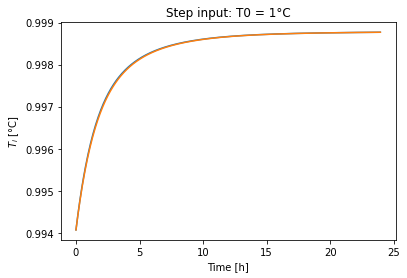

In [26]:
plt.plot(t/(2*3600), y_exp[1].T, t / (2*3600), y_imp[1].T)
plt.xlabel('Time [h]')
plt.ylabel('$T_i$ [°C]')
plt.title('Step input: T0 = 1°C')
plt.show()

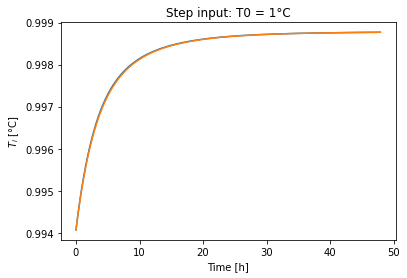

When there is no P-controller ($K_p = 10^{-3}$), the time response is short (less than 40 hours).

#### Simulation with weather data

In this part, we do the simulation with a weather data file. This file is simplified to be able to compare the results of our Python modelling with the results from the simulation on DesignBuilder.

We use the data for two days in 2000 : from January $3^{rd}$ to January $5^{th}$.

In [27]:
# Simulation with weather data
# ----------------------------
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-01-04 12:00:00'   # 1983

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

FileNotFoundError: [Errno 2] No such file or directory: 'FRA_Lyon.074810_IWEC.epw'

The weather data file gives us temperatures with a time-step of 1 hour. We need to interpolate it in the aim of simulating with a time-step of $dt$.

In [ ]:
# Interpolate weather data for time step dt
data = pd.concat([weather['temp_air']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')

The indoor temperature setpoint is $T_2 = 21°C$ in the living room and $T_3 = 23°C$ in the bathroom.

As a reminder, the temperature in the neighboring apartments and in the corridor is fixed at $T_1 = 20°C$.

The indoor temperature setpoints $T_2$ and $T_3$ and the auxiliary heat flow $Q_a$ are constant for the whole simulation period.

In [ ]:
# Indoor temperature set-point
data['T2'] = 21 * np.ones(data.shape[0])
data['T3'] = 23 * np.ones(data.shape[0])
# Fix temperature set-point
data['T1'] = 20 * np.ones(data.shape[0])

data = data.rename(columns={'temp_air': 'T0'})

# Indoor auxiliary heat flow rate
data['Qa'] = 0 * np.ones(data.shape[0])
data['Q0'] = 0 * np.ones(data.shape[0])

The input vector $u$ is composed by the temperature sources and the heat flow sources.

In [ ]:
u = pd.concat([data['T0'], data['T1'], data['T0'], data['T1'], data['T0'],
               data['T2'], data['T0'], data['T1'], data['T0'], data['T3'],
               data['T0'], data['Q0'], data['Q0'], data['Q0'], data['Q0'],
               data['Qa'], data['Q0'], data['Q0'], data['Qa'], data['Q0'],
               data['Q0'], data['Q0'], data['Q0']], axis=1)

The simulation time vector, at time step $dt$ is :

In [ ]:
# time
t = dt * np.arange(data.shape[0])

The initial value of the state-vector is fixed at 20°C :

In [ ]:
# initial values for temperatures
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

As before, the explicit Euler integration in time is :
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$

It gives the time variation of state variable $\theta$. With it, we calculate the variation of the indoor temperature and the variation of the heat flow of the HVAC system :
$$y = C_s \theta + D_s u$$
and
$$q_{HVAC} = K_p (T_{i,sp} - y)$$
Where : 
- $K_p$ is the gain of the P-controller
- $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature

In [28]:
I = np.eye(As.shape[0])
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
# Indoor temperature
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
# HVAC heat flow
q_HVAC_LR = Kp * (data['T2'] - y_exp[0, :])
q_HVAC_BR = Kp * (data['T3'] - y_exp[0, :])

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

We outline the figure of the evolution of temperature inside and outside the apartement during two days :
**CHECK COMMENT FAIRE POUR 2EME PIECE**

In [ ]:
# plot indoor and outdoor temperature
plt.plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
plt.plot(t / 3600, data['T0'], label='$T_{outdoor}$')
plt.xlabel('Time [h]')
plt.ylabel('Temperatures [°C]')
plt.title('Simulation for weather')
plt.legend(loc='upper right')
plt.show()

We also outline the figure of the evolution of heat flow inside in the two rooms during two days :

In [ ]:
# plot HVAC heat flow
plt.plot(t / 3600, q_HVAC_LR, label='$q_{HVAC LR}$')
plt.plot(t / 3600, q_HVAC_BR, label='$q_{HVAC BR}$')
plt.xlabel('Time [h]')
plt.ylabel('Heat flows [W]')
plt.title('Simulation for weather')
plt.legend(loc='upper right')
plt.show()

### Ameliorations ?

In [ ]:
pour avoir Qhvac smooth sans bumps

### Comparison with DesignBuilder model

## PART 2 - ENERGY EFFICIENT DESIGN

### General presentation of the building